# FashionMNIST VAE

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD, RMSprop
from torchvision import utils
from helper_functions import *
from sklearn.manifold import TSNE
from PIL import Image

### Define the simulation parameters

In [2]:
params = { 
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28, 
    'DIM_Z':20,
    'SCALE': 1.0,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

{'CHANNELS': 1, 'SCALE': 1.0, 'DIM_Z': 20, 'HEIGHT': 28, 'use_cuda': True, 'WIDTH': 28}


### Get the data

torch.Size([4, 1, 28, 28])


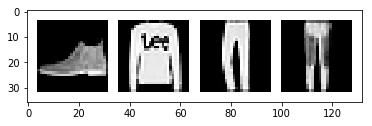

In [3]:
BATCH_SIZE = 512
kwargs = {'num_workers': 0, 'pin_memory': params["use_cuda"]}
data_dir = "/home/jupyter/REPOS/VAE_PYRO"
#data_dir = "/home/ldalessi/REPOS/VAE_PYRO"
#data_dir = "/Users/ldalessi/VAE_PYRO"


trainset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs_test,labels = next(iter(testloader))
if(params['use_cuda']):
    imgs_test=imgs_test[:4].cuda()

print(imgs_test.shape)
show_batch(imgs_test,npadding=4)

# VAE in PYTORCH

In [4]:
from encoder_decoder import *
from vae import *
encoder = Encoder_CONV(params)
decoder = Decoder_CONV(params)
vae = VAE(params,encoder,decoder)

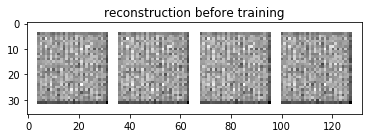

In [5]:
imgs_rec = vae.reconstruct(imgs_test)
show_batch(imgs_rec,nrow=4,npadding=4,title="reconstruction before training")
plt.savefig("rec_before_training_g_1.0.png")

[epoch 000] train loss: 612.7250 lr: 1.0000e-04
[epoch 001] train loss: 304.1839 lr: 1.0000e-04
[epoch 002] train loss: 253.3121 lr: 1.0000e-04
[epoch 003] train loss: 230.3317 lr: 1.0000e-04
[epoch 004] train loss: 213.2842 lr: 1.0000e-04
[epoch 005] train loss: 201.8628 lr: 1.0000e-04
[epoch 006] train loss: 193.5453 lr: 1.0000e-04
[epoch 007] train loss: 186.4647 lr: 1.0000e-04
[epoch 008] train loss: 181.6376 lr: 1.0000e-04
[epoch 009] train loss: 177.2345 lr: 1.0000e-04
[epoch 010] train loss: 173.5788 lr: 1.0000e-04
[epoch 011] train loss: 170.2997 lr: 1.0000e-04
[epoch 012] train loss: 167.3437 lr: 1.0000e-04
[epoch 013] train loss: 164.6011 lr: 1.0000e-04
[epoch 014] train loss: 162.5445 lr: 1.0000e-04
[epoch 015] train loss: 160.2078 lr: 1.0000e-04
[epoch 016] train loss: 158.3292 lr: 1.0000e-04
[epoch 017] train loss: 156.7268 lr: 1.0000e-04
[epoch 018] train loss: 154.7144 lr: 1.0000e-04
[epoch 019] train loss: 153.7371 lr: 1.0000e-04
[epoch 020] train loss: 152.0871 lr: 1.0

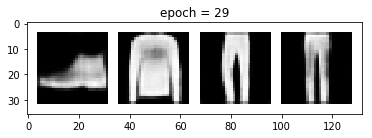

In [6]:
pt_optimizer = torch.optim.RMSprop(vae.parameters(),lr=1E-4)
pt_scheduler = torch.optim.lr_scheduler.StepLR(pt_optimizer, step_size=1, gamma=1.0, last_epoch=-1)

pt_hist_loss = []
pt_hist_lr = []
for epoch in range(30):
    loss_curr = train_VAE_pytorch(vae, trainloader, pt_optimizer, use_cuda = params['use_cuda'], verbose=(epoch==-1))
    lr_curr   = pt_optimizer.param_groups[0]['lr']
    print("[epoch %03d] train loss: %.4f lr: %.4e" % (epoch, loss_curr, lr_curr))
    pt_hist_loss.append(loss_curr)  
    pt_hist_lr.append(lr_curr)
    pt_scheduler.step()
    if(np.isnan(loss_curr)):
        break 
        
    imgs_rec = vae.reconstruct(imgs_test)
    show_batch(imgs_rec,nrow=4,npadding=4,title="epoch = "+str(epoch))
    plt.savefig("PYTORCH_rec_epoch_g_1.0_"+str(epoch)+".png")

### Show pytorch results

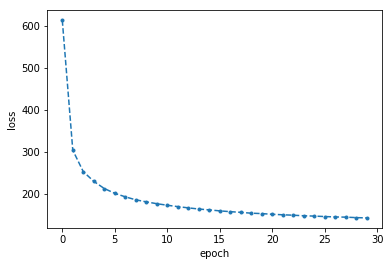

In [10]:
plt.plot(pt_hist_loss,'.--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig("PYTORCH_train_g_1.0.png")

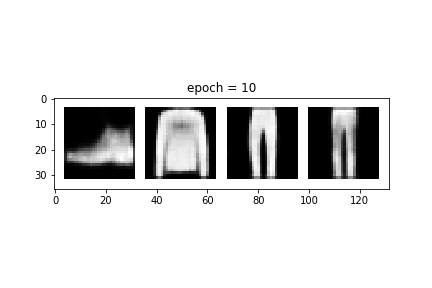

In [11]:
#intermediate reconstrucxtion
epoch = 10
path="./PYTORCH_rec_epoch_g_1.0_"+str(epoch)+".png"
display(Image.open(path))

# VAE in PYRO

In [12]:
from encoder_decoder import *
from vae import *
encoder = Encoder_CONV(params)
decoder = Decoder_CONV(params)
vae = VAE(params,encoder,decoder)

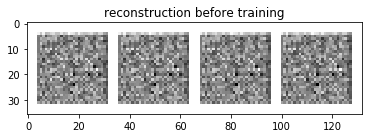

In [13]:
imgs_rec = vae.reconstruct(imgs_test)
show_batch(imgs_rec,nrow=4,npadding=4,title="reconstruction before training")
plt.savefig("rec_before_training_g_1.0.png")

[epoch 000] train loss: 1903.0320 lr: 1.0000e-04
[epoch 001] train loss: 393.7106 lr: 1.0000e-04
[epoch 002] train loss: 105.6855 lr: 1.0000e-04
[epoch 003] train loss: -18.2850 lr: 1.0000e-04
[epoch 004] train loss: -104.9225 lr: 1.0000e-04
[epoch 005] train loss: -171.7243 lr: 1.0000e-04
[epoch 006] train loss: -225.8897 lr: 1.0000e-04
[epoch 007] train loss: -267.8063 lr: 1.0000e-04
[epoch 008] train loss: -302.2390 lr: 1.0000e-04
[epoch 009] train loss: -331.9724 lr: 1.0000e-04
[epoch 010] train loss: -354.3748 lr: 1.0000e-04
[epoch 011] train loss: -377.7327 lr: 1.0000e-04
[epoch 012] train loss: -396.0151 lr: 1.0000e-04
[epoch 013] train loss: -414.0086 lr: 1.0000e-04
[epoch 014] train loss: -426.1296 lr: 1.0000e-04
[epoch 015] train loss: -438.7699 lr: 1.0000e-04
[epoch 016] train loss: -448.5549 lr: 1.0000e-04
[epoch 017] train loss: -458.3566 lr: 1.0000e-04
[epoch 018] train loss: -465.9600 lr: 1.0000e-04
[epoch 019] train loss: -473.6162 lr: 1.0000e-04
[epoch 020] train loss:

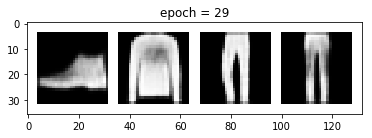

In [14]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

optimizer_args = {'lr': 1E-4}
scheduler_args = {'optimizer': torch.optim.RMSprop, 'step_size' : 1, 'gamma' : 1.0, 'optim_args' : optimizer_args}

pyro_scheduler = pyro.optim.StepLR(scheduler_args)
svi = SVI(vae.model, vae.guide, pyro_scheduler, loss=Trace_ELBO(num_particles=1))

pr_hist_loss = []
pr_hist_lr = []
    
for epoch in range(0,30):
    
    loss_curr = train(svi, trainloader, use_cuda=params['use_cuda'], verbose=False)
    lr_curr   = pyro_scheduler.pt_optim_args['lr']
    print("[epoch %03d] train loss: %.4f lr: %.4e" % (epoch, loss_curr, lr_curr))
    pr_hist_loss.append(loss_curr)  
    pr_hist_lr.append(lr_curr)
    if(np.isnan(loss_curr)):
        break 
        
    imgs_rec = vae.reconstruct(imgs_test)
    show_batch(imgs_rec,nrow=4,npadding=4,title="epoch = "+str(epoch))
    plt.savefig("PYRO_rec_epoch_g_1.0_"+str(epoch)+".png")

### Show PYRO results

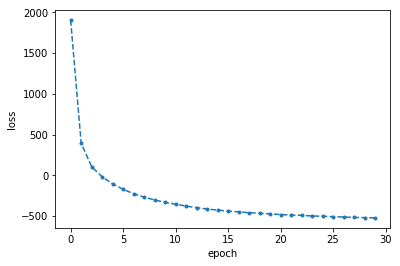

In [15]:
plt.plot(pr_hist_loss,'.--')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig("PYRO_train_g_1.0.png")

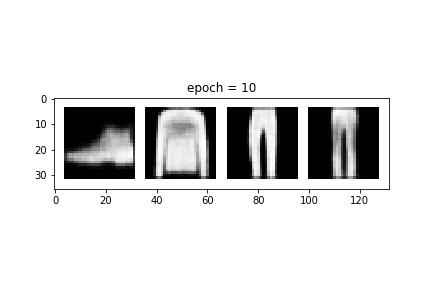

In [16]:
epoch = 10
path="./PYRO_rec_epoch_g_1.0_"+str(epoch)+".png"
display(Image.open(path))